# Fashion-MNIST Classifier
**P2963116**

### Project Brief
1. Experience building and training Artificial Neural Networks (ANNs) for classification problems.
2. Experience preprocessing image datasets.
3. Experience implementing and testing neural networks in Python using PyTorch/TensorFlow.
4. Experience comparing different neural architectures (ANN vs. CNN).

The goal of this project is to create a working classifier for use on the Fashion-MNIST dataset and to compare different architectures' performance.
I will be using *PyTorch* primarily, but also *SciKit-Learn* and *MatPlotLib* to create my project and display output data.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, Compose
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print('PyTorch version:', torch.__version__)
print('PyTorch working with CUDA:', torch.cuda.is_available())

PyTorch version: 2.9.0+cu130
PyTorch working with CUDA: True


### Data import and pre-processing
Using Torchvision's datasets module we can easily import our dataset. It also comes with the built-in method 'transform' allowing us to preprocess our data. In this case we use the ToTensor method and Normalize to store the images correctly and normalise pixel values.

Additionally the DataLoader allows us to automatically batch and shuffle our training and test datasets should we wish. In this case we only really need to shuffle the training data as we will not be adjusting weights using the test dataset.

I have also added a couple of asserts to ensure our data was loaded correctly (through checking the shape). In this case there should be no issues.

In [2]:
# Ordered list of data labels as per Fashion MNIST Documentation
data_labels = ["T-Shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal",
               "Shirt", "Sneaker", "Bag", "Ankle Boot"]

# Data pre-processing transformations
transforms = Compose([
    ToTensor(), 
    Normalize(mean=0.5, std=0.5)
])

# Initialise data
training_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = transforms
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = transforms
)

# Train on 80%, reserve remainder for validation
train_size = int(0.8 * len(training_data))
val_size = len(training_data) - train_size
train_subset, val_subset = random_split(training_data, [train_size, val_size])

# Batch Size (default = 64)
batch_size = 64

# Load the data with automatic shuffling for training/validation
train_loader = DataLoader(train_subset, batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=False)

train_images, train_labels = next(iter(train_loader))
val_images, val_labels = next(iter(val_loader))
test_images, test_labels = next(iter(test_loader))

# Tests
train_expected_size = torch.Size([batch_size,1,28,28])
assert train_images.shape == train_expected_size

expected_label_size = torch.Size([batch_size])
assert train_labels.shape == expected_label_size

### Example Image with label
Here we take the first image in one of our training batches and display using MatPlotLib, the title is its associated label.

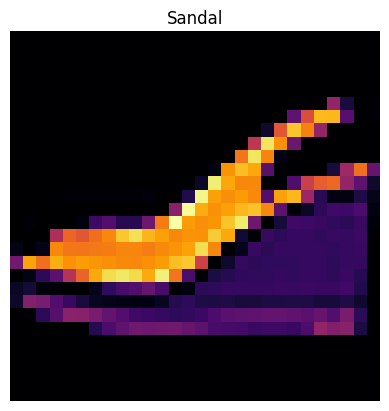

In [3]:
# Plot of random sample with label
img = train_images[0].squeeze()
label = data_labels[train_labels[0]]

fig = plt.imshow(img)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.set_cmap('inferno')
plt.title(label)
plt.show()

## Building our ANN
Using PyTorch it is very easy to create a simple network using global variables and nn.Sequential, however using a class will give us some flexibility in the width of our model while allowing for non-destructive testing to occur while optimising our network architecture.
Furthermore, for the sake of comparison there exists 2 possible architectures within this class, one which contains dropout and another which does not. Initially, the linear model was tested using no dropout however as we will see below, we later implemented dropout to prevent overfitting from occuring during the training process.
Each class we create inherits from the nn.Module class and requires an init function as well as a forward function which defines the forward pass of the network.

### Init
In the init function we first inherit everything from nn.Module and then specify our ReLU stack. This is defined using a series of linear perceptrons and ReLU activation layers. In the  case of using dropout, we also add dropout layers into the sequence between each layer. Additionally we also specify a flatten method which enables us to input the raw tensor data directly from the DataLoader without having to store the flattened image tensors as a global variable.
For more information on the arguments see the comments in the code itself.

### Forward
This is very simple, it applies a forward pass to our model where we then apply Logarithmic Softmax to the output (as this is a classification task).

In [4]:
# Define a class for an MLP (dropout optional)
class MultilayerPerceptron(nn.Module):
    def __init__(self, hidden1,hidden2,hidden3,in_features=28*28, out_features=10,use_dropout=False,dropout_prob=0.2):
        '''
        Multi-Layer Perceptron with specifiable hidden layer widths and optional use of dropout
        Args:
            hidden1 (int): specify the number of neurons in layer 1
            hidden2 (int): specify the number of neurons in layer 2
            hidden3 (int): specify the number of neurons in layer 3
            in_features (int/optional): specify the number of inputs (size of flattened image = length * width)
            out_features (int/optional): specify the number of outputs (number of classes)
            use_dropout (bool/optional): enable dropout
            dropout_prob (float/option): specify dropout probability. (default = 0.2)
        '''
        super().__init__()
        self.flatten = nn.Flatten()
        if use_dropout:
            self.lin_relu_stack = nn.Sequential(
                nn.Linear(in_features,hidden1),
                nn.ReLU(),
                nn.Dropout(dropout_prob),
                nn.Linear(hidden1, hidden2),
                nn.ReLU(),
                nn.Dropout(dropout_prob),
                nn.Linear(hidden2,hidden3),
                nn.ReLU(),
                nn.Dropout(dropout_prob),
                nn.Linear(hidden3, out_features),
            )
        else:
            self.lin_relu_stack = nn.Sequential(
                nn.Linear(in_features, hidden1),
                nn.ReLU(),
                nn.Linear(hidden1, hidden2),
                nn.ReLU(),
                nn.Linear(hidden2, hidden3),
                nn.ReLU(),
                nn.Linear(hidden3, out_features)
             )

    def forward(self, x):
        '''
        Perform a forward pass of the network.
        Note: This flattens the image for us so we need not reshape input data.
        Args:
            x (tensor): datapoint from our data
        '''
        x = self.flatten(x)
        output = self.lin_relu_stack(x)
        output = F.log_softmax(output, dim=1)
        return output

## CNN Architecture
Much the same as with the ANN, we create a class to define our CNN. This also inherits from nn.Module. Unlike the ANN, we do not need to flatten our input data until we have passed it through the convolution layers

### Init
Once again we inherit everything from the parent class nn.Module. Next we create a sequence of 2D-Convolution and MaxPool layers, a flatten method (identical to our ANN class) and a sequence of dense layers using ReLU as the activation functions.

### Forward
We define the forward pass by sending our input through the convolution stack before flattening this output. The flattened tensor is then, just as with the ANN sent through the dense layers before Log Softmax is applied and our output is returned.

In [5]:
# Define our CNN Architecture
class CNNNetwork(nn.Module):
    '''
    Defines a simple Convolutional Neural Network with 2 convolution layers and 2 instances of MaxPooling. Dropout p=0.2 in the dense layers.
    Args:
    in_channels (int): number of input channels. 1 for greyscale, 3 for rgb images etc.
    out_channels (int): number of classes
    filters1 (int): number of filters in convolution block 1
    filters2 (int): number of filters in convolution block 2
    kernel1 (int/tuple): kernel size in conv block 1
    kernel2 (int/tuple): kernel size in conv block 2
    stride1 (int): stride for conv block 1
    stride2 (int): stride for conv block 2
    '''
    def __init__(self,in_channels,out_channels,filters1,filters2,kernel1=3,kernel2=3,stride1=1,stride2=1):
        super().__init__()
        self.convstack = nn.Sequential(
            nn.Conv2d(in_channels,filters1,kernel1,stride1),
            nn.ReLU(),
            nn.Conv2d(filters1,filters1,kernel1,stride1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(filters1,filters2,kernel2,stride2),
            nn.ReLU(),
            nn.Conv2d(filters2,filters2,kernel2,stride2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )
        self.flatten = nn.Flatten()
        self.dense = nn.Sequential(
            nn.Linear(filters2 * 4 * 4, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64,out_channels),
        )
    def forward(self,x):
        output = self.convstack(x)
        output = self.flatten(output)
        output = self.dense(output)
        output = F.log_softmax(output,dim=1)
        return output

## Train/Test Functions
Since we are defining multiple models, it would be nice to just write the code to train and test once, hence we will use a function here instead of global variables.
### Train
This function outlines the training process in any given epoch. We first enable training mode using the train() method, calculate the muber of batches and set our total loss to 0 (for a specified criterion).
Now we iterate over all the items in our dataset using a for loop.
We zero the gradient calculations before performing a forward pass of our model and calculating the loss. We then backpropagate using the backward() method and use the step() method to update the training parameters based on our optimiser. We finally add the training loss for every item before calculating the mean loss per batch. 
This value is then printed and returned.
### Test
Similar to the train function, however we need not specify an optimiser as we will not be updating any weights.
The eval() method sets our model to evaluation mode, meaning parameters will not be updated as we iterate over the data. Since we are going to be recording accuracy we need both the number of batches and number of samples for our given dataloader. 
We perform the forward pass of our model with no gradients calculated but this time we also want to check if the prediction is correct so we may calculate the accuracy of the model.

In [6]:
# Define a train and test function for use with our models
def train(dataloader, model, loss_fn, optimizer):
    '''
    Perform a simple training pass for one epoch
    Args:
        dataloader (Dataloader(data)): Dataloader using torchvision
        model (ANN/CNN): Chosen model
        loss_fn: Loss function used
        optimizer: optimiser used for gradient parameter adjustment
    '''
    model.train()
    num_batch = len(dataloader)
    train_loss = 0.
    for X,label in dataloader:
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= num_batch
    return train_loss

def test(dataloader, model,loss_fn):
    '''
    Perform a test pass.
    Args:
        dataloader (DataLoader(data)): Dataloader of a dataset using torchvision
        model (ANN/CNN): Chosen model
        loss_fn: Loss function
    '''
    model.eval()
    num_batch = len(dataloader)
    samples = len(dataloader.dataset)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for X,label in dataloader:
            pred = model(X)
            loss = loss_fn(pred, label)
            test_loss += loss.item()
            pred = pred.argmax(1)
            correct += (pred == label).type(torch.float).sum().item()
    test_loss /= num_batch
    accuracy = correct/samples * 100
    return test_loss, accuracy

## Combining train and test
Finally, we want to call a single function which can iterate our training and test datasets over a specified number of epochs. To track our losses and accuracy we store these values in a list where each item in loss_hist is itself a list containing the training loss and the test loss, while accuracy_hist only contains the accuracy of the model on the test dataset.
These lists are returned for use in plotting.

In [7]:
# Train/test loop combined, we will use accuracy as our primary metric
def run(train_loader,val_loader, test_loader, model, epochs,loss_fn,optimizer):
    '''
    Runs our model train and test loop for a specified number of epochs
    Args:
    train_loader (Dataloader(data)): Training data
    val_loader (Dataloader(data)): Validation data
    test_loader (Dataloader(data)): Test data
    model (MultilayerPerceptron): Model
    epochs (int): Number of epochs
    '''
    loss_hist = []
    accuracy_hist = []
    for e in range(epochs):
        print(f'Epoch {e+1}/{epochs}')
        train_loss = train(train_loader, model, loss_fn, optimizer)
        print(f'Training loss = {train_loss:>5f}')
        val_loss, val_accuracy = test(val_loader, model,loss_fn)
        print(f'Validation loss = {val_loss:>5f} (Accuracy = {val_accuracy:.2f}%)')
        loss_hist.append([train_loss,val_loss])
        accuracy_hist.append(val_accuracy)
    # Return test acc for final epoch
    print('Switching to test set:')
    _, test_accuracy = test(test_loader, model, loss_fn)
    print(f'Final accuracy on test set: {test_accuracy:.2f}%')
    return loss_hist, accuracy_hist, test_accuracy

## Confusion matrix
In addition, it is nice to visualise the confusion matrix for our models so we can easily identify potential shortcomings of our model, and also debug any potential issues. For example, I was consistently facing an issue where my model was unable to produce any predictions for index 6: "Shirt", caused by a bottleneck in network width. Without the use of the visualisation it was difficult to understand why my model had limited accuracy.

In [8]:
# Confusion matrix plotter
def ConfMatDisplay(dataloader, model):
    '''
    Create a confusion matrix and plot
    Args:
        dataloader (Dataloader(data)): Option to use a custom dataloader for test data
        model (ANN/CNN): Model
    '''
    predictions = []
    labels = []
    for data, label in dataloader:
        pred = model(data)
        pred = pred.argmax(1)
        predictions += pred.tolist()
        labels += label.tolist()
    cm = confusion_matrix(labels, predictions)
    ConfusionMatrixDisplay(cm, display_labels = data_labels).plot(xticks_rotation='vertical', cmap = 'inferno')

## The first model
Initially I had opted to use layer widths of 512,256,128 (as was used in the lab material), but as mentioned above, it led to issues with the model being unable to predict an entire category of label. Upon changing to values which are divisors of our input lengths, the performance of the model jumped with an increase in accuracy of around 10%.
### Hyperparameters
To start we will use the fairly standard value of 0.001 as our learn rate and I decided on 30 epochs for training as this would mean the model takes around 5 minutes to exectute a full train/test loop with my RTX 3070ti. It also means there is plenty of time to observe potential problems such as overfitting and underfitting when plotting the results.
### Loss function and Optimiser Choice
Initially, We will be using Negative Log Likelihood as our loss function and Adam as our optimiser. We can also use Stochastic Gradient Descent, another good choice for classifier tasks and something we will see used in the comparison graphs below.

In [9]:
# Initialise ANN and show structure
ann_model = MultilayerPerceptron(392,196,98)
print(ann_model)

# Hyperparameters
learn_rate = 1e-3
epochs = 30

# initialise loss function and optimiser
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(ann_model.parameters(), lr=learn_rate)

MultilayerPerceptron(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): ReLU()
    (2): Linear(in_features=392, out_features=196, bias=True)
    (3): ReLU()
    (4): Linear(in_features=196, out_features=98, bias=True)
    (5): ReLU()
    (6): Linear(in_features=98, out_features=10, bias=True)
  )
)


In [10]:
# Train and test the model based on hyperparameters
ann_hist, ann_accuracy, ann_taccuracy = run(train_loader, val_loader, test_loader, ann_model, epochs, loss_fn, optimizer)

Epoch 1/30
Training loss = 0.531889
Validation loss = 0.455040 (Accuracy = 83.54%)
Epoch 2/30
Training loss = 0.385520
Validation loss = 0.366879 (Accuracy = 86.64%)
Epoch 3/30
Training loss = 0.347495
Validation loss = 0.363593 (Accuracy = 86.75%)
Epoch 4/30
Training loss = 0.320174
Validation loss = 0.340259 (Accuracy = 87.71%)
Epoch 5/30
Training loss = 0.296058
Validation loss = 0.353573 (Accuracy = 87.75%)
Epoch 6/30
Training loss = 0.278698
Validation loss = 0.332978 (Accuracy = 88.26%)
Epoch 7/30
Training loss = 0.266299
Validation loss = 0.324059 (Accuracy = 88.47%)
Epoch 8/30
Training loss = 0.250301
Validation loss = 0.337177 (Accuracy = 88.27%)
Epoch 9/30
Training loss = 0.240178
Validation loss = 0.328758 (Accuracy = 88.67%)
Epoch 10/30
Training loss = 0.228652
Validation loss = 0.345813 (Accuracy = 88.45%)
Epoch 11/30
Training loss = 0.214058
Validation loss = 0.350555 (Accuracy = 88.90%)
Epoch 12/30
Training loss = 0.209101
Validation loss = 0.324447 (Accuracy = 89.28%)
E

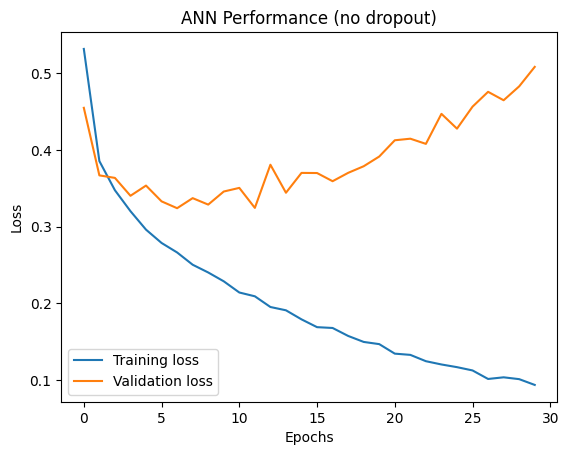

In [11]:
# Plot loss history against epochs
plt.plot(ann_hist, label=["Training loss","Validation loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("ANN Performance (no dropout)")
plt.legend()
plt.show()

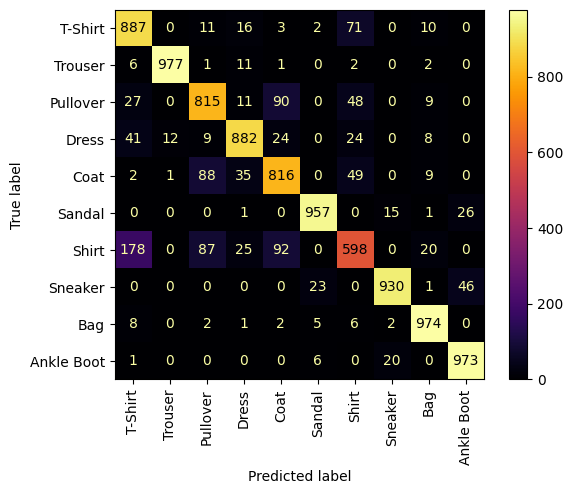

In [12]:
# Visualise confusion matrix for our first model
ConfMatDisplay(test_loader, ann_model)

## Evaluation


## Preventing overfitting: dropout
In order to prevent the overfitting that occurs during training we implement dropout between each layer to randomly switch off connections between layers during training. I built  this feature into the class so we initalise the same network but with use_dropout set to True. We are using a probability of 0.2 so on average 80% of the connections between layers will remain active during training.

In [13]:
# Define a new ANN with dropout for comparison
ann_dropout = MultilayerPerceptron(392,196,98,use_dropout=True)
print(ann_dropout)
dropout_optimizer = torch.optim.Adam(ann_dropout.parameters(), lr=learn_rate)

MultilayerPerceptron(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=392, out_features=196, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=196, out_features=98, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=98, out_features=10, bias=True)
  )
)


In [14]:
# Train and test
dropout_hist, dropout_accuracy, dropout_taccuracy = run(train_loader, val_loader,test_loader, ann_dropout, epochs, loss_fn, dropout_optimizer)

Epoch 1/30
Training loss = 0.589290
Validation loss = 0.457073 (Accuracy = 82.97%)
Epoch 2/30
Training loss = 0.436685
Validation loss = 0.400075 (Accuracy = 84.94%)
Epoch 3/30
Training loss = 0.391229
Validation loss = 0.373443 (Accuracy = 86.79%)
Epoch 4/30
Training loss = 0.371397
Validation loss = 0.360965 (Accuracy = 86.98%)
Epoch 5/30
Training loss = 0.354623
Validation loss = 0.364991 (Accuracy = 87.51%)
Epoch 6/30
Training loss = 0.340062
Validation loss = 0.346791 (Accuracy = 87.98%)
Epoch 7/30
Training loss = 0.326048
Validation loss = 0.349788 (Accuracy = 87.50%)
Epoch 8/30
Training loss = 0.313909
Validation loss = 0.338975 (Accuracy = 88.26%)
Epoch 9/30
Training loss = 0.307260
Validation loss = 0.336166 (Accuracy = 88.24%)
Epoch 10/30
Training loss = 0.298706
Validation loss = 0.356750 (Accuracy = 88.04%)
Epoch 11/30
Training loss = 0.293424
Validation loss = 0.318512 (Accuracy = 88.96%)
Epoch 12/30
Training loss = 0.283524
Validation loss = 0.332165 (Accuracy = 88.91%)
E

What we immediately notice from the outputs of our train/test functions is the loss values are much closer together and we only begin to see the impact of overfitting towards later epochs. What this does fully mitigate is the loss on the validation set diverging entirely so the model no longer becomes more incorrect with further training (at least  from our chosen epoch count). We can see a clear visual representation of this in the plot below:

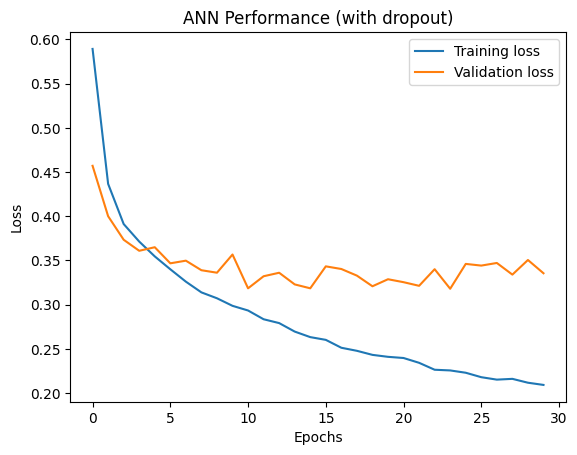

In [15]:
# Plot loss history
plt.plot(dropout_hist, label=["Training loss","Validation loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("ANN Performance (with dropout)")
plt.legend()
plt.show()

### Confusion Matrix
We can see here a clear impact on the precision of our model as there is a more even spread of incorrect results. There is nearly a 10 percentage point improvement in performance in how well the model classifies shirts correctly for example.

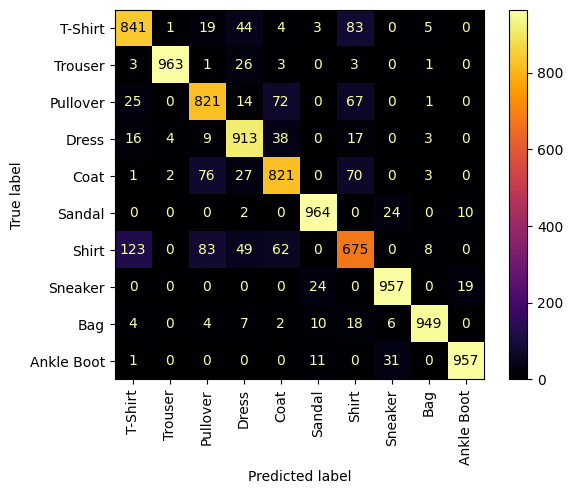

In [16]:
# Visualise confusion matrix
ConfMatDisplay(test_loader,ann_dropout)

## CNN Architecture

In [17]:
# Initialise with hyperparameters
cnn = CNNNetwork(in_channels=1,out_channels=10,filters1=32,filters2=64)
print(cnn)
cnn_optimizer = torch.optim.Adam(cnn.parameters(), lr=learn_rate)

CNNNetwork(
  (convstack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [18]:
# Train and test
cnn_hist, cnn_accuracy, cnn_taccuracy = run(train_loader,val_loader, test_loader, cnn,epochs,loss_fn,cnn_optimizer)

Epoch 1/30
Training loss = 0.764017
Validation loss = 0.460776 (Accuracy = 83.07%)
Epoch 2/30
Training loss = 0.467895
Validation loss = 0.350761 (Accuracy = 87.64%)
Epoch 3/30
Training loss = 0.383803
Validation loss = 0.300204 (Accuracy = 89.08%)
Epoch 4/30
Training loss = 0.337229
Validation loss = 0.281986 (Accuracy = 89.80%)
Epoch 5/30
Training loss = 0.310119
Validation loss = 0.261284 (Accuracy = 90.34%)
Epoch 6/30
Training loss = 0.287466
Validation loss = 0.255154 (Accuracy = 90.70%)
Epoch 7/30
Training loss = 0.267881
Validation loss = 0.258299 (Accuracy = 90.94%)
Epoch 8/30
Training loss = 0.253137
Validation loss = 0.255585 (Accuracy = 90.59%)
Epoch 9/30
Training loss = 0.235564
Validation loss = 0.247478 (Accuracy = 91.44%)
Epoch 10/30
Training loss = 0.226949
Validation loss = 0.242760 (Accuracy = 91.34%)
Epoch 11/30
Training loss = 0.211619
Validation loss = 0.249741 (Accuracy = 91.63%)
Epoch 12/30
Training loss = 0.203738
Validation loss = 0.244376 (Accuracy = 91.53%)
E

### Loss evaluation and performance
The most obvious thing about our model is that unlike the ANNs, we are easily able pass the 90% accuracy breakpoint. The current architecture however does display some clear signs of overfitting as we begin to see increases in the validation loss values in later epochs. This occurs in spite of implementing dropout in the dense layers and may suggest that we would be better to implement early stopping at around 15 epochs to get better performance out of our model.

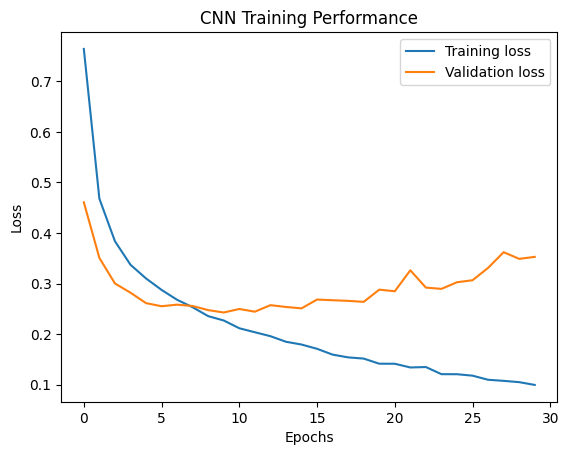

In [19]:
# Plot loss history
plt.plot(cnn_hist, label=["Training loss","Validation loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("CNN Training Performance")
plt.legend()
plt.show()

### Confusion Matrix
We can see the CNN is the best perfomer so far, especially with regards to the problematic classification of shirts. There is a clear improvement in precision where we once again see an uplift in the minimum number of correct predictions. 

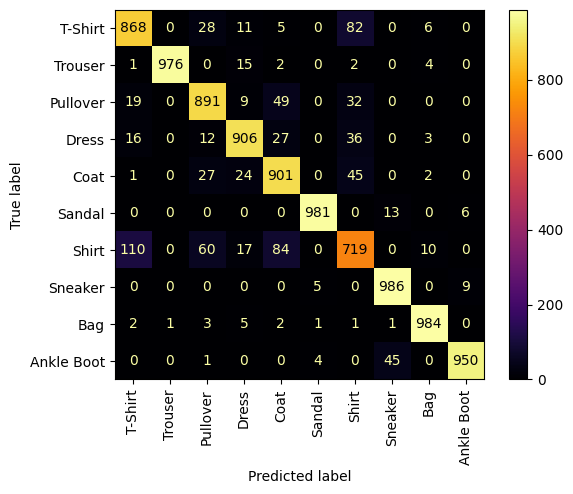

In [20]:
# Visualise confusion matrix
ConfMatDisplay(test_loader,cnn)

### Comparing Model Accuracy
Below is a plot of the models' performance on the validation set in training. I note that there is minimal impact to accuracy when implementing dropout in spite of how noticable the improvements to stability are.

The CNN is very clearly the 'winner' when it comes to classifying test data correctly, scoring 3-4% better than both the ANN models.

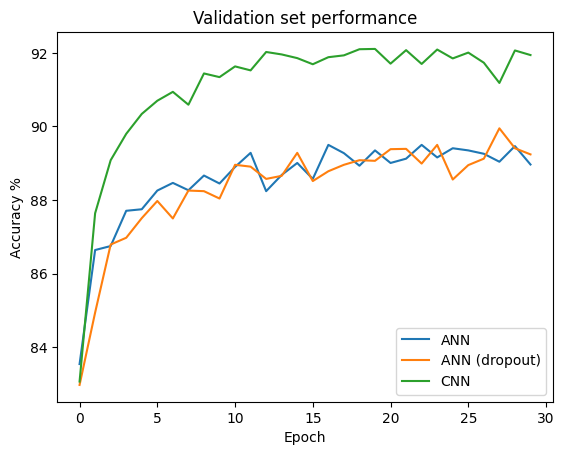

In [21]:
# Comparative plot of test accuracy across epochs
plt.plot(ann_accuracy,label="ANN")
plt.plot(dropout_accuracy,label="ANN (dropout)")
plt.plot(cnn_accuracy,label="CNN")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.title("Validation set performance")
plt.legend()
plt.show()

### Test Set Accuracy Comparison

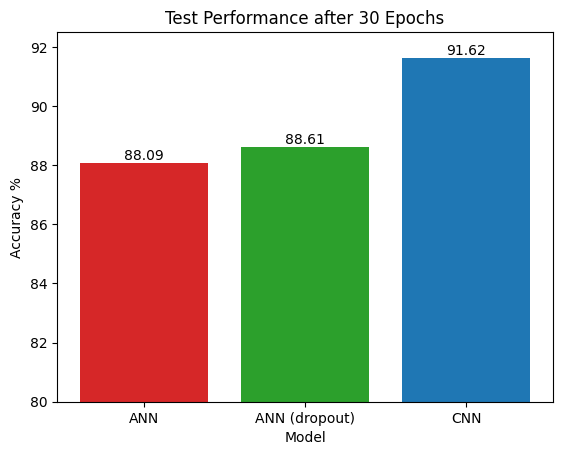

In [23]:
# Test performance comparison
x = ['ANN','ANN (dropout)','CNN']
accuracy_data = [ann_taccuracy,dropout_taccuracy,cnn_taccuracy]
barchart = plt.bar(x,accuracy_data,color=['tab:red','tab:green','tab:blue'])
plt.bar_label(barchart, fmt='{:,.2f}')
plt.ylim(80,92.5)
plt.xlabel('Model')
plt.ylabel('Accuracy %')
plt.title(f'Test Performance after {epochs} Epochs')
plt.show()